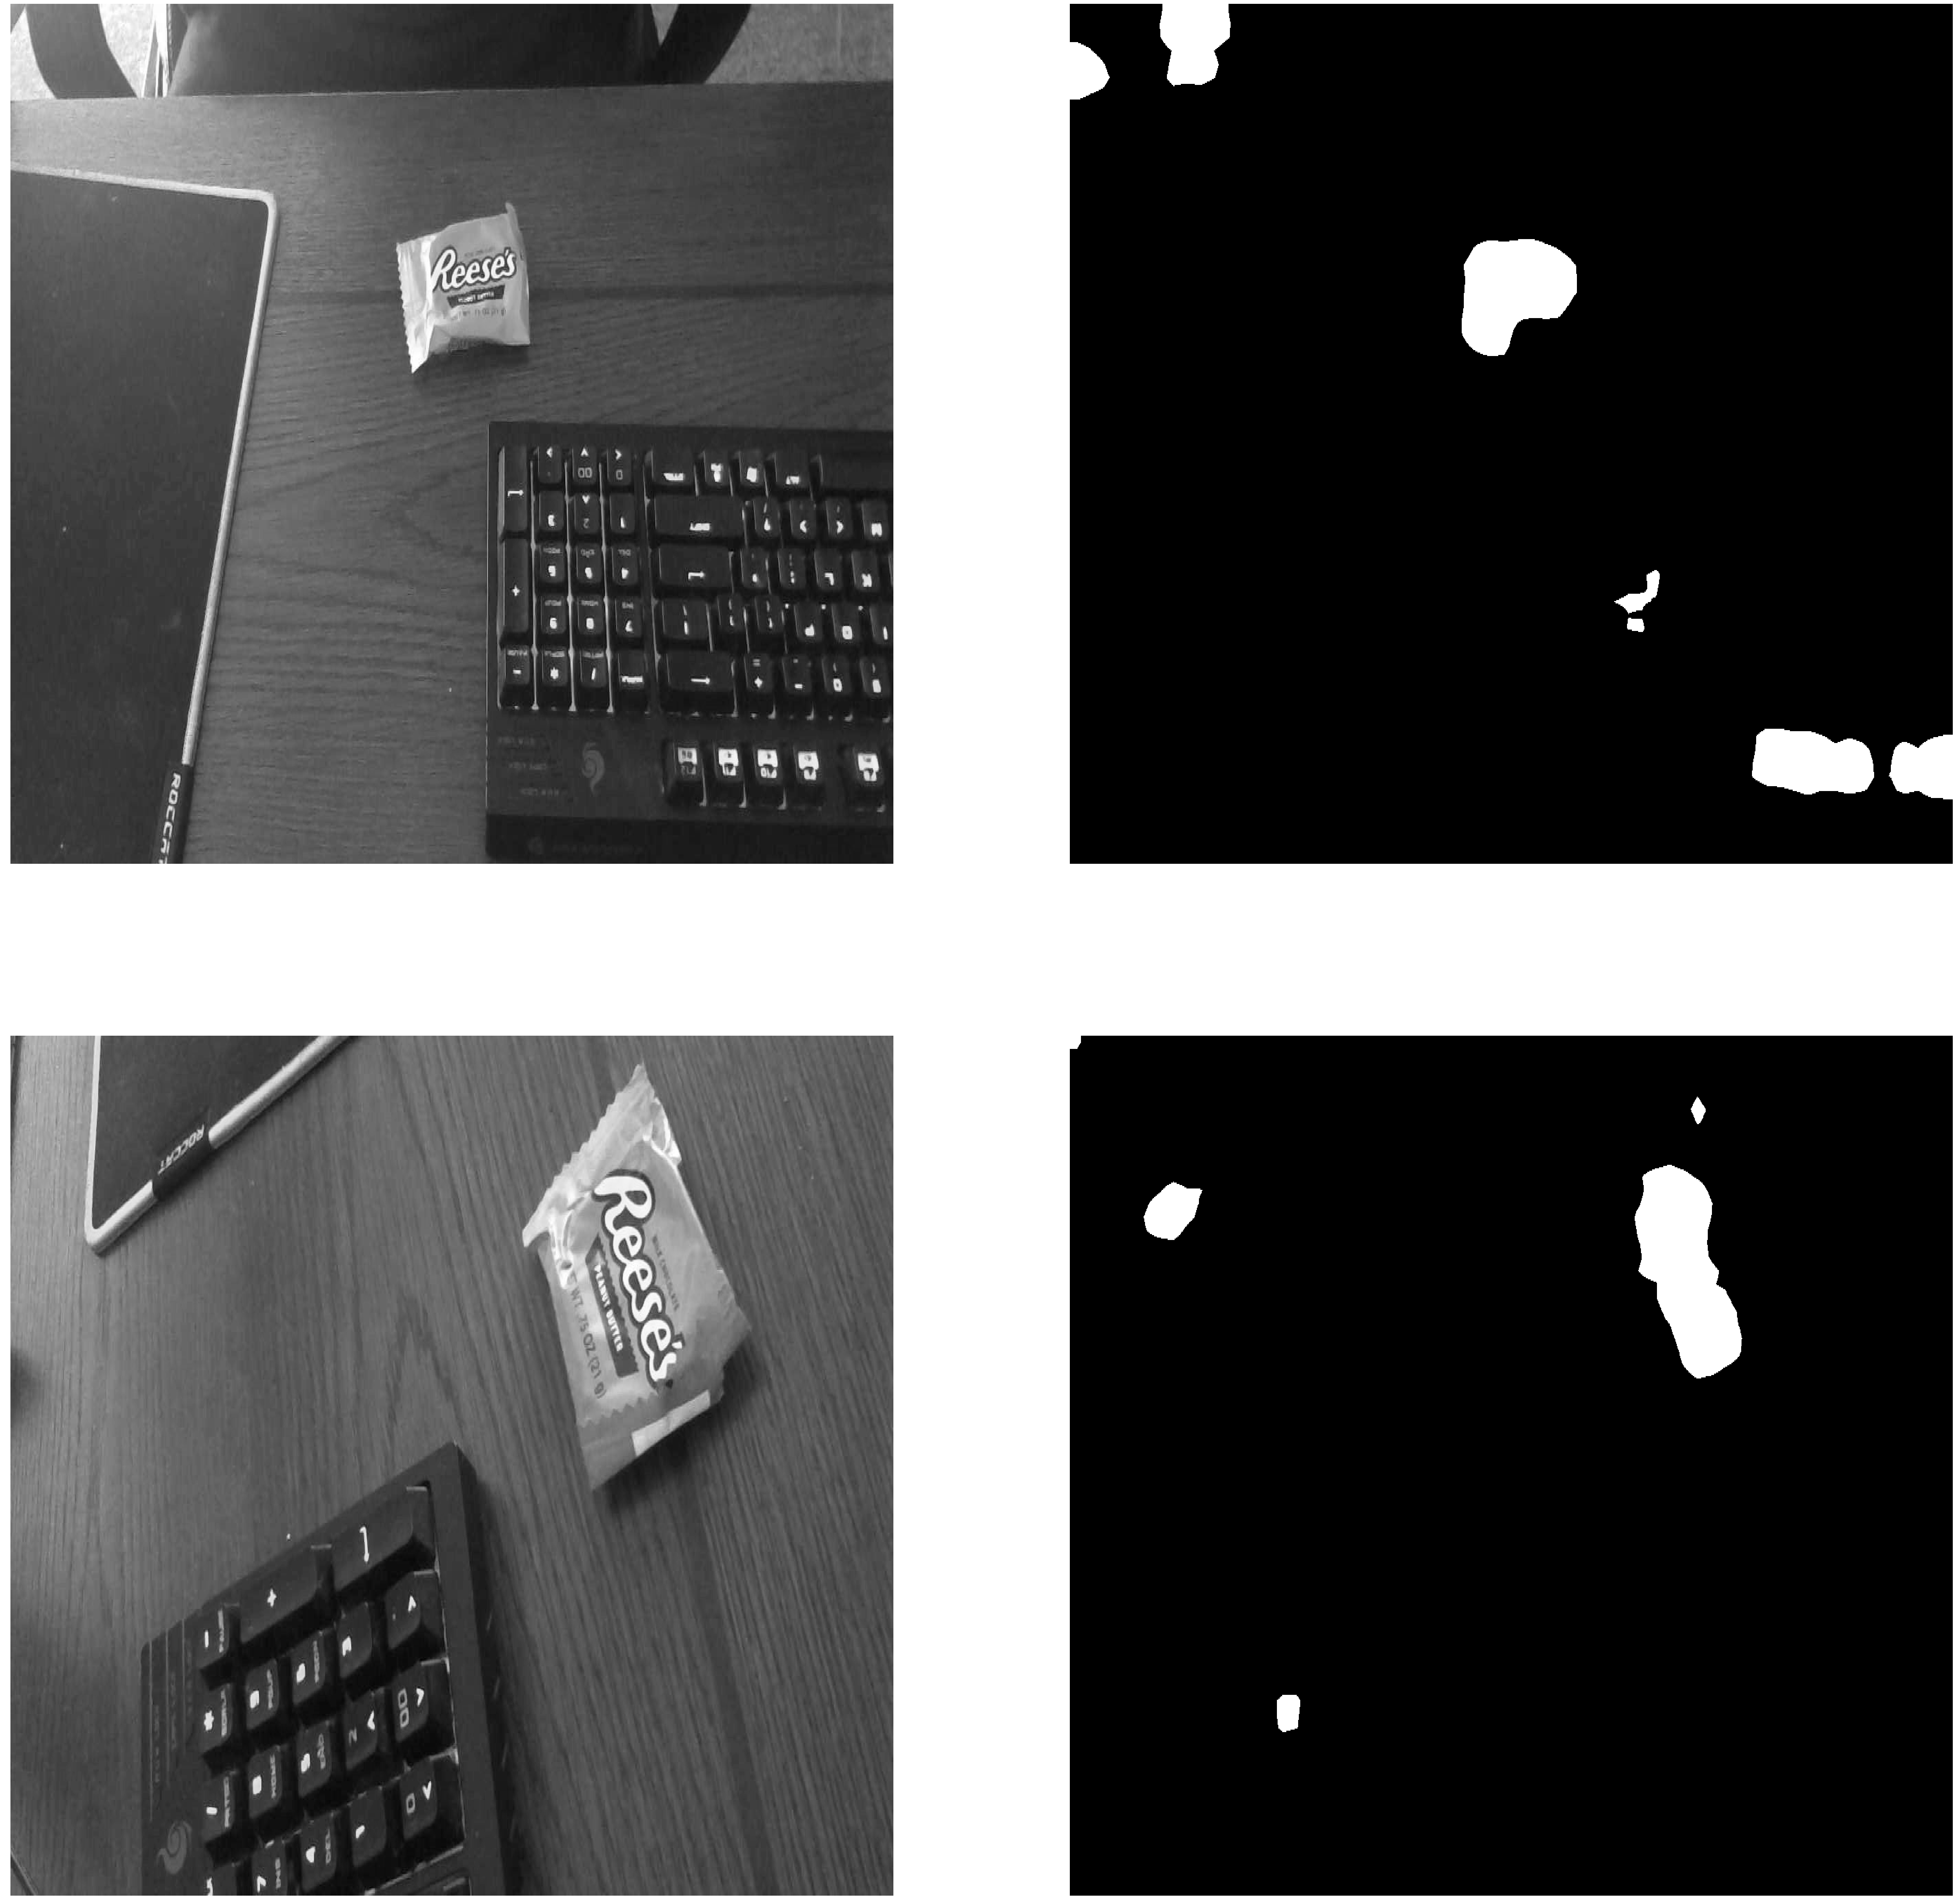

In [28]:
'''
Detecting and Displaying Image Salience with a Binary Threshold
'''

%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the images in gray scale
img1 = cv2.imread('images/scene_with_candy.jpg', 0)
img2 = cv2.imread('images/scene_with_candy_2.jpg', 0)

### Detect Salience
saliencyDetector = cv2.saliency.StaticSaliencySpectralResidual_create()

success, img1Values = saliencyDetector.computeSaliency(img1, None)
success, img2Values = saliencyDetector.computeSaliency(img2, None)

threshold = 0.4

img1Values[img1Values < threshold] = 0
img1Values[img1Values > threshold] = 1

img2Values[img2Values < threshold] = 0
img2Values[img2Values > threshold] = 1

###

# Create subplots to show images
f, axarr = plt.subplots(2,2,figsize=(100,100))

plt.gray()

# Hide axes
axarr[0,0].axis('off')
axarr[0,1].axis('off')
axarr[1,0].axis('off')
axarr[1,1].axis('off')

# Display images in plot
axarr[0,0].imshow(img1, interpolation='nearest', extent=[0,400,0,1], aspect='auto')
axarr[0,1].imshow(img1Values, interpolation='nearest', extent=[0,400,0,1], aspect='auto')
axarr[1,0].imshow(img2, interpolation='nearest', extent=[0,400,0,1], aspect='auto')
axarr[1,1].imshow(img2SalienceImg, interpolation='nearest', extent=[0,400,0,1], aspect='auto')

plt.show()

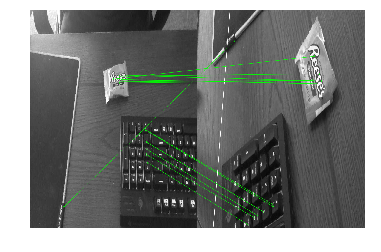

In [10]:
'''
Feature Matching using ORB Feature Detector and Binary Descriptor

ORB feature detection using an oriented FAST detection method and rotated BRIEF descriptors.
'''

%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# Load the images in gray scale
img1 = cv2.imread('images/scene_with_candy.jpg', 0)
img2 = cv2.imread('images/scene_with_candy_2.jpg', 0)


### Detect Salience
saliencyDetector = cv2.saliency.StaticSaliencySpectralResidual_create()
success, img1Values = saliencyDetector.computeSaliency(img1, None)
success, img2Values = saliencyDetector.computeSaliency(img2, None)

threshold = 0.16
img1LowValues = img1Values < threshold
img1HighValues = img1Values < threshold
img1Values[img1LowValues] = 0
img1Values[img1HighValues] = 1

img1SalienceMask = np.asarray(Image.fromarray(img1Values * 255))
img2SalienceMask = np.asarray(Image.fromarray(img1Values * 255))


#img1 = cv2.bitwise_and(img1,img1,mask = img1SalienceMask)
#img2 = cv2.bitwise_and(img2,img2,mask = img2SalienceMask)
###

# Detect the SIFT key points and compute the descriptors for the two images
sift = cv2.xfeatures2d.SIFT_create()
keyPoints1, descriptors1 = sift.detectAndCompute(img1, None)
keyPoints2, descriptors2 = sift.detectAndCompute(img2, None)

# Create brute-force matcher object
bf = cv2.BFMatcher()

# Match the descriptors
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

# Select the good matches using the ratio test
goodMatches = []

for m, n in matches:
    if m.distance < 0.7 * n.distance:
        goodMatches.append(m)

# Apply the homography transformation if we have enough good matches 
MIN_MATCH_COUNT = 10

if len(goodMatches) > MIN_MATCH_COUNT:
    # Get the good key points positions
    sourcePoints = np.float32([ keyPoints1[m.queryIdx].pt for m in goodMatches ]).reshape(-1, 1, 2)
    destinationPoints = np.float32([ keyPoints2[m.trainIdx].pt for m in goodMatches ]).reshape(-1, 1, 2)
    
    # Obtain the homography matrix
    M, mask = cv2.findHomography(sourcePoints, destinationPoints, method=cv2.RANSAC, ransacReprojThreshold=5.0)
    matchesMask = mask.ravel().tolist()
    
    # Apply the perspective transformation to the source image corners
    h, w = img1.shape
    corners = np.float32([ [0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0] ]).reshape(-1, 1, 2)
    transformedCorners = cv2.perspectiveTransform(corners, M)
    
    # Draw a polygon on the second image joining the transformed corners
    img2 = cv2.polylines(img2, [np.int32(transformedCorners)], True, (255, 255, 255), 2, cv2.LINE_AA)
else:
    print("Not enough matches are found - %d/%d" % (len(goodMatches), MIN_MATCH_COUNT))
    matchesMask = None

# Draw the matches
drawParameters = dict(matchColor=(0, 255, 0), singlePointColor=None, matchesMask=matchesMask, flags=2)
result = cv2.drawMatches(img1, keyPoints1, img2, keyPoints2, goodMatches, None, **drawParameters)

# Display the results
plt.axis("off")
plt.imshow(result, extent=[0,400,0,1], aspect='auto')
plt.show()

# Downsize image
#result = cv2.resize(result, None, fx=0.6, fy=0.6, interpolation = cv2.INTER_CUBIC)

# Display the results
#cv2.imshow('Homography', result)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

